# Part 3 - Introduction to RNN, GRU, LSTM

##Example 1 : Secondary structure prediction

First, import some modules necessary for data analysis and transformation:

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm

Mount google drive:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
%mkdir workshop-tmp
%cd  /content/drive/MyDrive/workshop-tmp
%pwd

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘workshop-tmp’: File exists
/content/drive/MyDrive/workshop-tmp


'/content/drive/MyDrive/workshop-tmp'

In [ ]:
def download_data():
  x_pssm500_DatasetTrainUrl    ='https://www.dsimb.inserm.fr/~gelly/data/x_pssm500.csv';
  x_aaindex500_DatasetValidUrl ='https://www.dsimb.inserm.fr/~gelly/data/x_aaindex500.csv';
  y_bfact_DatasetTrainUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_bfact500.csv';
  y_class_DatasetValidUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_class500.csv';
  datasetFolderPath = "dataset/"

  trainpssmFilePath     = os.path.join(datasetFolderPath, 'x_pssm500.csv')
  trainaaindexFilePath  = os.path.join(datasetFolderPath, 'x_aaindex500.csv')
  yclassFilePath        = os.path.join(datasetFolderPath, 'y_class500.csv')
  ybfactFilePath        = os.path.join(datasetFolderPath, 'y_bfact500.csv')


  if not os.path.exists(datasetFolderPath):
    os.makedirs(datasetFolderPath)

  def download_file(url, filename):
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                       total=int(response.headers.get('content-length', 0)),
                       desc=filename) as fout:
                       for chunk in response.iter_content(chunk_size=4096):
                         fout.write(chunk)

  if not os.path.exists(trainpssmFilePath):
    download_file(x_pssm500_DatasetTrainUrl, trainpssmFilePath)

  if not os.path.exists(trainaaindexFilePath):
    download_file(x_aaindex500_DatasetValidUrl, trainaaindexFilePath)

  if not os.path.exists(yclassFilePath):
    download_file(y_class_DatasetValidUrl, yclassFilePath)

  if not os.path.exists(ybfactFilePath):
    download_file(y_bfact_DatasetTrainUrl, ybfactFilePath)



In [ ]:
download_data()

Read the data to variables (it will take some time for x since we have a lot of data):

In [ ]:
X = np.loadtxt('dataset/x_pssm500.csv')

In [ ]:
Y = np.loadtxt('dataset/y_class500.csv')

In [ ]:
YB =  np.loadtxt('dataset/y_bfact500.csv')

In [ ]:
Y_class =  np.loadtxt('dataset/y_class500.csv')

In [ ]:
# cmap = plt.cm.get_cmap('PiYG', 7)

# Data analysis

How many examples do we have in our dataset?

In [ ]:
print(f'X:\n {X}\nY:\n{Y}')
print(f'Shape of data X:{X.shape}\n')
print(f'Shape of data Y:{Y.shape}\n')

X:
 [[0.     0.     0.     ... 0.0159 0.188  0.    ]
 [0.     0.     0.     ... 0.0196 0.1862 0.    ]
 [0.     0.     0.     ... 0.0445 0.1348 0.    ]
 ...
 [0.052  0.0055 0.0503 ... 0.     0.     1.    ]
 [0.0509 0.0055 0.0552 ... 0.     0.     1.    ]
 [0.0506 0.0058 0.0503 ... 0.     0.     1.    ]]
Y:
[6. 3. 3. ... 3. 6. 6.]
Shape of data X:(99083, 330)

Shape of data Y:(99083,)



We will simplify our data for the first tests using only three types of SS. Once everything works, you can get back to the initial data.

In [ ]:
Y3cl = np.zeros(len(Y))
Y3cl[((Y==0) | (Y==1) | (Y==2))] = 0 # helix H
Y3cl[((Y==3) | (Y==4))] = 1          # strand E
Y3cl[((Y==5) | (Y==6))] = 2          # coil C

In [ ]:
# Frequency
print(f'Number of Helices: {sum(Y3cl==0)}\n')
print(f'Number of Strands: {sum(Y3cl==1)}\n')
print(f'Number of Coils: {sum(Y3cl==2)}\n')

Number of Helices: 40657

Number of Strands: 23022

Number of Coils: 35404



What is our class distribution?

<BarContainer object of 3 artists>

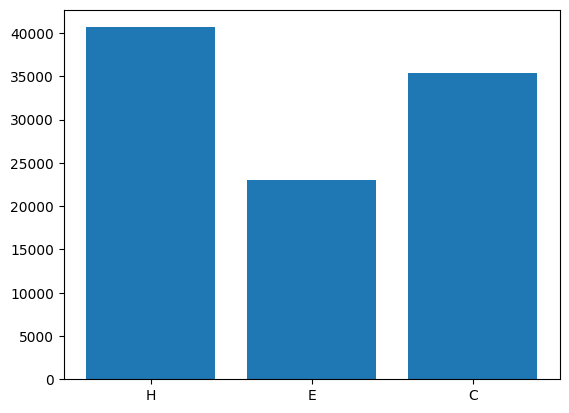

In [ ]:
unique, counts = np.unique(Y3cl, return_counts=True)
plt.bar(["H", "E", "C"], counts)

# Prediction model

## Preparation

We import some modules for deep learning model construction.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN, GRU, LSTM, Flatten

#from keras.wrappers.scikit_learn import KerasClassifier
# Utily function from keras
#from keras.utils import np_utils
from keras.utils import to_categorical
# Plot model
from keras.utils import plot_model
# Optimizers
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

One hot encoding of class Y

In [ ]:
y_oh = to_categorical(Y3cl)
print(f'One hot encoding of y : {y_oh}\n')
print(f'Shape of y_oh : {y_oh.shape}')

One hot encoding of y : [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

Shape of y_oh : (99083, 3)


Tu successfully use CNN, we need to convert our data:

In [ ]:
print(f'X shape : {X.shape}')
x_cnn = X.reshape(len(X), 15, 22)
print(f'X reshaped : {x_cnn.shape}')

X shape : (99083, 330)
X reshaped : (99083, 15, 22)


We will also prepare our data for training by splitting data into train and validation sets:

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.2, random_state=3, shuffle=True)
Xcnn_train, Xcnn_test, y_train, y_test = train_test_split(x_cnn, y_oh, test_size=0.2, random_state=3, shuffle=True)

# Classification

### Simple RNN:

In [ ]:
def RNN_model():
    hidden_units = 32
    input_shape  = (15,22)
    dense_units  = 3
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation="sigmoid",return_sequences=True))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 15, 32)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,443 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,203 (12.51 KB)

 Trainable params: 3,203 (12.51 KB)

 Non-trainable params: 0 (0.00 B)

None


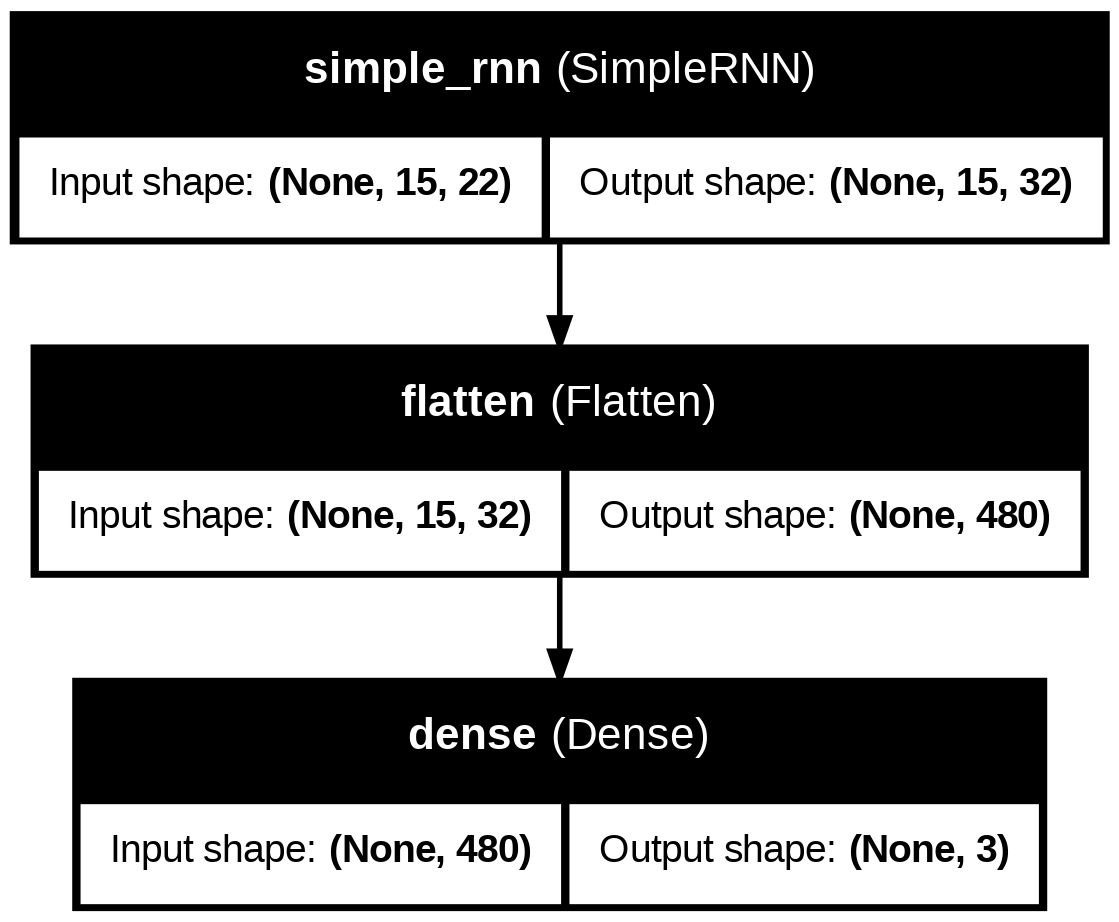

In [ ]:
model = RNN_model()
print(f'{model.summary()}')
plot_model(model, to_file="model.png",
               show_shapes=True, show_layer_names=True)

In [ ]:
# Fit model
#history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=20, batch_size=50)
history = model.fit(Xcnn_train, y_train, validation_split = 0.2, epochs=20, batch_size=50)
#history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20, batch_size=50)

Epoch 1/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4046 - loss: 1.0816 - val_accuracy: 0.5167 - val_loss: 0.9761
Epoch 2/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5882 - loss: 0.9087 - val_accuracy: 0.6651 - val_loss: 0.7686
Epoch 3/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6797 - loss: 0.7626 - val_accuracy: 0.7007 - val_loss: 0.7254
Epoch 4/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6966 - loss: 0.7289 - val_accuracy: 0.6902 - val_loss: 0.7473
Epoch 5/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6995 - loss: 0.7148 - val_accuracy: 0.7099 - val_loss: 0.6960
Epoch 6/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7064 - loss: 0.7049 - val_accuracy: 0.7129 - val_loss: 0.6902
Epoch 7/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7100 - loss: 0.6988 - val_accuracy: 0.7076 - val_loss: 0.6906
Epoch 8/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7134 - loss: 0.6882 -

Did the model successfully train? Plot different metrics and evolution of train/validation loss using the code below.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


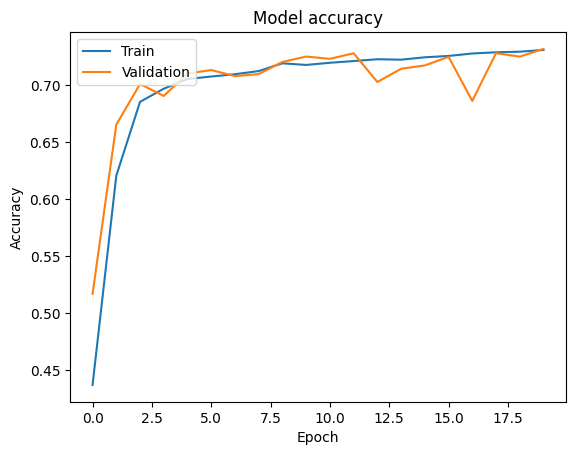

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

How does the model perform for the independent test ?

In [ ]:
model.evaluate(Xcnn_test,y_test)

620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7248 - loss: 0.6689


[0.6592642068862915, 0.7304839491844177]

1. Try a different architecture: GRU network

In [ ]:
def GRU_model():
    hidden_units = 32
    input_shape  = (15,22)
    dense_units  = 3
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation="sigmoid",return_sequences=True))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 32)         │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,443 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,819 (26.64 KB)

 Trainable params: 6,819 (26.64 KB)

 Non-trainable params: 0 (0.00 B)

None


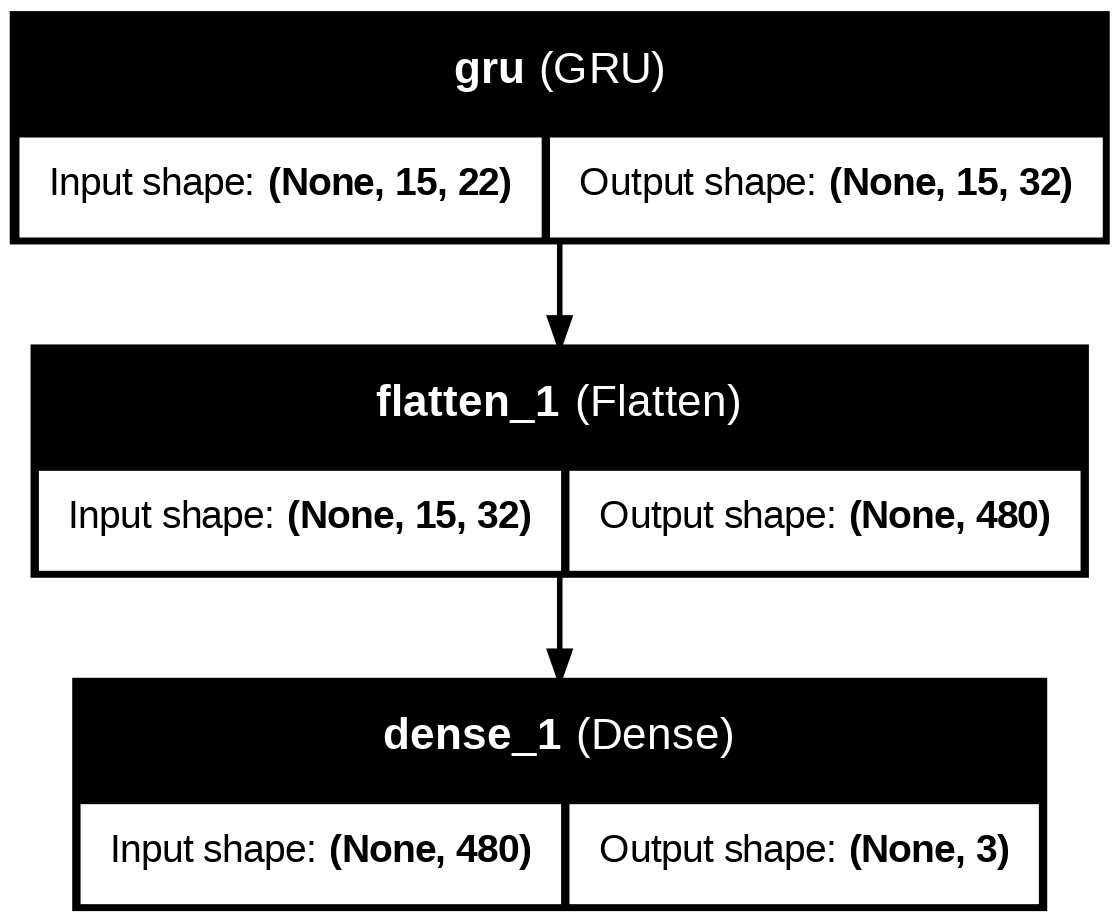

In [ ]:
model = GRU_model()
print(f'{model.summary()}')
plot_model(model, to_file="model.png",
               show_shapes=True, show_layer_names=True)

In [ ]:
# Fit model
#history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=20, batch_size=50)
history = model.fit(Xcnn_train, y_train, validation_split = 0.2, epochs=20, batch_size=50)
#history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20, batch_size=50)

Epoch 1/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4166 - loss: 1.0720 - val_accuracy: 0.5412 - val_loss: 0.9736
Epoch 2/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5931 - loss: 0.9009 - val_accuracy: 0.6149 - val_loss: 0.8172
Epoch 3/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6752 - loss: 0.7604 - val_accuracy: 0.6929 - val_loss: 0.7183
Epoch 4/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7031 - loss: 0.7116 - val_accuracy: 0.7110 - val_loss: 0.6946
Epoch 5/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7078 - loss: 0.7074 - val_accuracy: 0.6964 - val_loss: 0.7063
Epoch 6/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7091 - loss: 0.6983 - val_accuracy: 0.6947 - val_loss: 0.7230
Epoch 7/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7150 - loss: 0.6884 - val_accuracy: 0.7133 - val_loss: 0.6800
Epoch 8/20
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7191 - loss: 0.6802 -

2. Try a different architecture: LSTM network